In [ ]:
!pip install tensorflow

In [ ]:
import os
import pandas as pd
import tensorflow as tf
import numpy as np

In [ ]:
from tensorflow.keras.layers import TextVectorization

X = df['comment_text']
y = df[df.columns[2:]].values

print(X)

0         Explanation\nWhy the edits made under my usern...
1         D'aww! He matches this background colour I'm s...
2         Hey man, I'm really not trying to edit war. It...
3         "\nMore\nI can't make any real suggestions on ...
4         You, sir, are my hero. Any chance you remember...
                                ...                        
159566    ":::::And for the second time of asking, when ...
159567    You should be ashamed of yourself \n\nThat is ...
159568    Spitzer \n\nUmm, theres no actual article for ...
159569    And it looks like it was actually you who put ...
159570    "\nAnd ... I really don't think you understand...
Name: comment_text, Length: 159571, dtype: object


In [ ]:
MAX_FEATURES = 200000

In [ ]:
vectorizer = TextVectorization(max_tokens=MAX_FEATURES,
                               output_sequence_length=1800,
                               output_mode='int')
vectorizer.adapt(X.values)
vectorized_text = vectorizer(X.values)

In [ ]:
dataset = tf.data.Dataset.from_tensor_slices((vectorized_text, y))
dataset = dataset.cache()
dataset = dataset.shuffle(160000)
dataset = dataset.batch(16)
dataset = dataset.prefetch(8)
train = dataset.take(int(len(dataset)*.7))
val = dataset.skip(int(len(dataset)*.7)).take(int(len(dataset)*.2))
test = dataset.skip(int(len(dataset)*.9)).take(int(len(dataset)*.1))

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dropout, Bidirectional, Dense, Embedding

In [ ]:
from tensorflow.keras.metrics import BinaryAccuracy

# Create the model
model = Sequential()
model.add(Embedding(MAX_FEATURES + 1, 32))
model.add(Bidirectional(LSTM(32, activation='tanh')))
model.add(Dense(128, activation='relu'))
model.add(Dense(256, activation='relu'))
model.add(Dense(128, activation='relu'))
model.add(Dense(6, activation='sigmoid'))

# Compile the model with BinaryCrossentropy loss and BinaryAccuracy metric
model.compile(loss='binary_crossentropy', optimizer='Adam', metrics=[BinaryAccuracy()])

# Print model summary
model.summary()

# Train the model and capture the history
history = model.fit(train, epochs=5, validation_data=val)

# Access accuracy values during training
train_accuracy = history.history['binary_accuracy']
val_accuracy = history.history['val_binary_accuracy']

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 32)          6400032   
                                                                 
 bidirectional (Bidirectiona  (None, 64)               16640     
 l)                                                              
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dense_1 (Dense)             (None, 256)               33024     
                                                                 
 dense_2 (Dense)             (None, 128)               32896     
                                                                 
 dense_3 (Dense)             (None, 6)                 774       
                                                        

<Figure size 800x500 with 0 Axes>

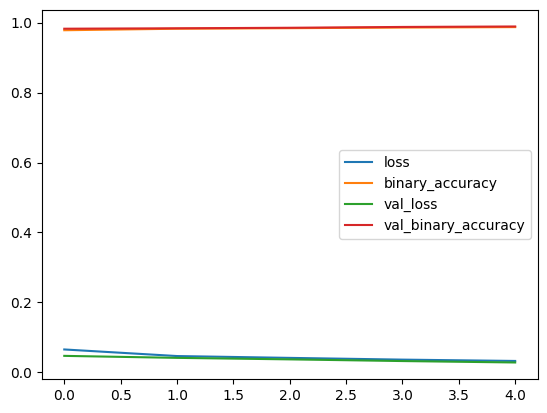

In [ ]:
from matplotlib import pyplot as plt

plt.figure(figsize=(8,5))
pd.DataFrame(history.history).plot()
plt.show()

In [ ]:

print("Train Accuracy:", train_accuracy[-1])
print("Validation Accuracy:", val_accuracy[-1])


Train Accuracy: 0.9872750043869019
Validation Accuracy: 0.9890713691711426


In [ ]:
from tensorflow.keras.metrics import Precision, Recall, CategoricalAccuracy
pre = Precision()
re = Recall()
acc = CategoricalAccuracy()
for batch in test.as_numpy_iterator():
    # Unpack the batch
    X_true, y_true = batch
    # Make a prediction
    yhat = model.predict(X_true)

1/1 [==============================] - 0s 53ms/step


In [ ]:
import tensorflow as tf

# Assuming you have already loaded and preprocessed the data and trained the model as per your previous code

# Test the model and make predictions
test_accuracy = model.evaluate(test)
print("Test Binary Accuracy:", test_accuracy[1])

# Make predictions on a sample batch of data
sample_batch = next(iter(test))
sample_inputs = sample_batch[0]
sample_labels = sample_batch[1]
predictions = model.predict(sample_inputs)

# Print sample predictions and labels
for i in range(len(sample_labels)):
    print("Sample", i+1)
    print("True Labels:", sample_labels[i])
    print("Predicted Labels:", predictions[i])
    print()
new_text_data = ['you freaking suck', 'great job!', 'not sure about this']

# Vectorize the new text data using the TextVectorization layer
new_vectorized_data = vectorizer(new_text_data)



# Make predictions using the trained model
new_predictions = model.predict(new_vectorized_data)

# Print predictions for the new data
for i, prediction in enumerate(new_predictions):
    print("New Data Sample", i+1)
    print("Input Text:", new_text_data[i])
    print("Predicted Labels:", prediction)
    print()


997/997 [==============================] - 38s 37ms/step - loss: 0.0268 - binary_accuracy: 0.9898
Test Binary Accuracy: 0.9898132085800171
1/1 [==============================] - 0s 77ms/step
Sample 1
True Labels: tf.Tensor([0 0 0 0 0 0], shape=(6,), dtype=int64)
Predicted Labels: [1.1844066e-05 2.5699050e-18 4.6596847e-07 4.5445838e-13 3.6906656e-08
 2.7715427e-10]

Sample 2
True Labels: tf.Tensor([0 0 0 0 0 0], shape=(6,), dtype=int64)
Predicted Labels: [1.3905773e-06 1.4542885e-20 4.3374094e-08 1.8997426e-14 2.3413425e-09
 3.7231909e-11]

Sample 3
True Labels: tf.Tensor([1 0 1 0 0 0], shape=(6,), dtype=int64)
Predicted Labels: [7.9272270e-01 7.5939187e-04 2.3841758e-01 2.5737940e-04 1.1293993e-01
 1.7557975e-03]

Sample 4
True Labels: tf.Tensor([1 1 1 0 1 0], shape=(6,), dtype=int64)
Predicted Labels: [0.9998822  0.41490373 0.9984503  0.01150032 0.9103281  0.0384924 ]

Sample 5
True Labels: tf.Tensor([0 0 0 0 0 0], shape=(6,), dtype=int64)
Predicted Labels: [1.2467656e-05 2.0381726e-